# TensorFlow 2.0

In [16]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%matplotlib inline

## Hyperparameter Tunning

In [17]:
num_epochs = 50
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [18]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [19]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['acc'])  # Metrics / Accuracy

# Data Preprocess

In [20]:
train_paths = glob('dataset/cifar/train/*.png')[:1000]
test_paths = glob('dataset/cifar/test/*.png')[:1000]

In [21]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [22]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [23]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [24]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [25]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [28]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

## Training

http://localhost:6006

In [29]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

history = model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

Epoch 1/50
31/31 [==============================] - 4s 117ms/step - loss: 2.3335 - acc: 0.1002 - val_loss: 2.3009 - val_acc: 0.1129
Epoch 2/50
31/31 [==============================] - 3s 111ms/step - loss: 2.2967 - acc: 0.1136 - val_loss: 2.2812 - val_acc: 0.1512
Epoch 3/50
31/31 [==============================] - 4s 122ms/step - loss: 2.2595 - acc: 0.1421 - val_loss: 2.2003 - val_acc: 0.1663
Epoch 4/50
31/31 [==============================] - 4s 118ms/step - loss: 2.1726 - acc: 0.1992 - val_loss: 2.1934 - val_acc: 0.1804
Epoch 5/50
31/31 [==============================] - 4s 136ms/step - loss: 2.1524 - acc: 0.1994 - val_loss: 2.0120 - val_acc: 0.2177
Epoch 6/50
31/31 [==============================] - 4s 132ms/step - loss: 2.0560 - acc: 0.2180 - val_loss: 1.9951 - val_acc: 0.2429
Epoch 7/50
31/31 [==============================] - 4s 132ms/step - loss: 2.0633 - acc: 0.2087 - val_loss: 2.0025 - val_acc: 0.2581
Epoch 8/50
31/31 [==============================] - 4s 128ms/step - loss: 1.

KeyboardInterrupt: 

# History 들여다 보기 

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
history.params

{'batch_size': None,
 'epochs': 50,
 'steps': 31,
 'samples': 31,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [25]:
new_model = history.model

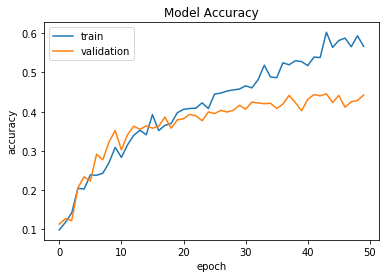

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

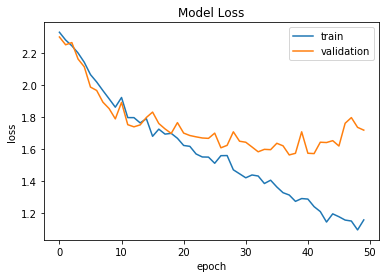

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()